# Predicting California Wildfire Damage
Global losses from wildfire has been increasing significantly in the last 10 years [1], partly due to climate change but also due to human actiona such as building near forested areas. The insurance industry and civil society have been using catastrophe models for years with some success to help manage similar perils such as hurricanes and earthquake, however, model development for wildfires is still immature. Unlike the two aforementioned perils where different model providers have been converging on a consenus on the view of risk, a consistent view of wildfire risk still eludes the industry and different models may give out glaringly divergent results.

This study aims to indepedently assess one component of catastrophe models, the vulnerability of structure to wildfire damage, using publicly available data which should eventually lead into a benchmark when assessing other commercial catastrophe models.

The data this study uses is the Wildfire Damage Inspection database of the Califironia Department of Forestry and Fire Prevention (Cal Fire) [2]. The aim is to develop a model the predicts a structures level of damage given its characteristics.

## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyproj
import time
import plotly.graph_objs as go
from itertools import product

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

sns.set_theme(context='notebook', style='darkgrid', palette='flare')

In [2]:
data_file_path = "All_Incidents_2013_2023_DINS_Excel.xlsx"
calfire_data = pd.read_excel("All_Incidents_2013_2023_DINS_Excel.xlsx",
                             na_values=' ')

calfire_data.head()

OBJECTID         * Damage  * Street Number  * Street Name  \
0         1        No Damage           8376.0   Quail Canyon   
1         2  Affected (1-9%)           8402.0   Quail Canyon   
2         3        No Damage           8430.0  Quail Canyon    
3         4        No Damage           3838.0    Putah Creek   
4         5        No Damage           3830.0    Putah Creek   

  * Street Type (e.g. road, drive, lane, etc.)  \
0                                         Road   
1                                         Road   
2                                         Road   
3                                         Road   
4                                         Road   

  Street Suffix (e.g. apt. 23, blding C)   * City State  Zip Code  \
0                                    NaN  Winters    CA       NaN   
1                                    NaN  Winters    CA       NaN   
2                                    NaN  Winters    CA       NaN   
3                                    NaN  Winters    CA       NaN   
4                                    NaN  Winters    CA       NaN   

  * CAL FIRE Unit  ... Distance - Propane Tank to Structure  \
0             LNU  ...                                  NaN   
1             LNU  ...                                  NaN   
2             LNU  ...                                  NaN   
3             LNU  ...                                  NaN   
4             LNU  ...                                  NaN   

  Distance - Residence to Utility/Misc Structure &gt; 120 SQFT  \
0                                                NaN             
1                                                NaN             
2                                                NaN             
3                                                NaN             
4                                                NaN             

  Fire Name (Secondary) APN (parcel) Assessed Improved Value (parcel)  \
0                 Quail   0101090290                         510000.0   
1                 Quail   0101090270                         573052.0   
2                 Quail   0101090310                         350151.0   
3                 Quail   0103010240                         134880.0   
4                 Quail   0103010220                         346648.0   

  Year Built (parcel)                    Site Address (parcel)  \
0              1997.0  8376 QUAIL CANYON RD VACAVILLE CA 95688   
1              1980.0  8402 QUAIL CANYON RD VACAVILLE CA 95688   
2              2004.0  8430 QUAIL CANYON RD VACAVILLE CA 95688   
3              1981.0     3838 PUTAH CREEK RD WINTERS CA 95694   
4              1980.0     3830 PUTAH CREEK RD WINTERS CA 95694   

                                 GLOBALID   Latitude   Longitude  
0  {16892726-1103-458A-A675-8C0BFA676862}  38.474960 -122.044465  
1  {70503D05-F319-4958-B64C-0D609BF4A81F}  38.477442 -122.043252  
2  {CF25E444-B3CC-4C34-B11C-58A207343997}  38.479358 -122.044585  
3  {154F1E8A-6128-4EA8-878E-576F863908DB}  38.487313 -122.015115  
4  {6C3F46C4-0FFB-4E59-80E6-553FDAE07C82}  38.485636 -122.016122  

[5 rows x 44 columns]

In [3]:
calfire_data.shape

(92113, 44)

In [4]:
calfire_data.columns

Index(['OBJECTID', '* Damage', '* Street Number', '* Street Name',
       '* Street Type (e.g. road, drive, lane, etc.)',
       'Street Suffix (e.g. apt. 23, blding C)', '* City', 'State', 'Zip Code',
       '* CAL FIRE Unit', 'County', 'Community', 'Battalion',
       '* Incident Name', 'Incident Number (e.g. CAAEU 123456)',
       'Incident Start Date', 'Hazard Type',
       'If Affected 1-9% - Where did fire start?',
       'If Affected 1-9% - What started fire?',
       'Structure Defense Actions Taken', '* Structure Type',
       'Structure Category', '# Units in Structure (if multi unit)',
       '# of Damaged Outbuildings < 120 SQFT',
       '# of Non Damaged Outbuildings < 120 SQFT', '* Roof Construction',
       '* Eaves', '* Vent Screen', '* Exterior Siding', '* Window Pane',
       '* Deck/Porch On Grade', '* Deck/Porch Elevated',
       '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure', 'Distance - Propane Tank to Structure',
       'Dis

#### Keep relevant columns

In [5]:
relevant_cols = ['OBJECTID',
                 '* Damage',
                 '* Structure Type',
                 '* Roof Construction',
                 '* Eaves',
                 '* Vent Screen',
                 '* Exterior Siding',
                 '* Window Pane',
                 '* Deck/Porch On Grade',
                 '* Deck/Porch Elevated',
                 '* Patio Cover/Carport Attached to Structure',
                 '* Fence Attached to Structure',
                 'Distance - Propane Tank to Structure',
                 'Assessed Improved Value (parcel)',
                 'Year Built (parcel)',
                 'Latitude', 'Longitude']

calfire_data_rel = calfire_data[relevant_cols].copy()

calfire_data_rel.head()

OBJECTID         * Damage                      * Structure Type  \
0         1        No Damage   Single Family Residence Multi Story   
1         2  Affected (1-9%)  Single Family Residence Single Story   
2         3        No Damage  Single Family Residence Single Story   
3         4        No Damage  Single Family Residence Single Story   
4         5        No Damage  Single Family Residence Single Story   

  * Roof Construction     * Eaves        * Vent Screen * Exterior Siding  \
0             Asphalt  Unenclosed  Mesh Screen <= 1/8"              Wood   
1             Asphalt  Unenclosed  Mesh Screen <= 1/8"              Wood   
2             Asphalt    Enclosed   Mesh Screen > 1/8"              Wood   
3             Asphalt  Unenclosed   Mesh Screen > 1/8"              Wood   
4                Tile    Enclosed   Mesh Screen > 1/8"              Wood   

  * Window Pane * Deck/Porch On Grade * Deck/Porch Elevated  \
0   Single Pane                  Wood                  Wood   
1    Multi Pane      Masonry/Concrete         No Deck/Porch   
2   Single Pane         No Deck/Porch         No Deck/Porch   
3   Single Pane         No Deck/Porch         No Deck/Porch   
4    Multi Pane                  Wood                  Wood   

  * Patio Cover/Carport Attached to Structure * Fence Attached to Structure  \
0                      No Patio Cover/Carport                      No Fence   
1                      No Patio Cover/Carport                   Combustible   
2                      No Patio Cover/Carport                      No Fence   
3                                 Combustible                      No Fence   
4                                 Combustible                      No Fence   

  Distance - Propane Tank to Structure  Assessed Improved Value (parcel)  \
0                                  NaN                          510000.0   
1                                  NaN                          573052.0   
2                                  NaN                          350151.0   
3                                  NaN                          134880.0   
4                                  NaN                          346648.0   

   Year Built (parcel)   Latitude   Longitude  
0               1997.0  38.474960 -122.044465  
1               1980.0  38.477442 -122.043252  
2               2004.0  38.479358 -122.044585  
3               1981.0  38.487313 -122.015115  
4               1980.0  38.485636 -122.016122

### Impute Missing Data

In [6]:
calfire_data_rel.isna().sum()

OBJECTID                                           0
* Damage                                           0
* Structure Type                                   0
* Roof Construction                             4731
* Eaves                                         5215
* Vent Screen                                   5303
* Exterior Siding                               5013
* Window Pane                                   5081
* Deck/Porch On Grade                          21593
* Deck/Porch Elevated                          21594
* Patio Cover/Carport Attached to Structure    21598
* Fence Attached to Structure                  21595
Distance - Propane Tank to Structure           70959
Assessed Improved Value (parcel)                6031
Year Built (parcel)                            30398
Latitude                                           0
Longitude                                          0
dtype: int64

In [7]:
# Data preprocessing
categorical_cols = [
    '* Structure Type',
    '* Roof Construction',
    '* Eaves',
    '* Vent Screen',
    '* Exterior Siding',
    '* Window Pane',
    '* Deck/Porch On Grade',
    '* Deck/Porch Elevated',
    '* Patio Cover/Carport Attached to Structure',
    '* Fence Attached to Structure',
    'Distance - Propane Tank to Structure'
]

# Set missing structure detail to Unknown
for c in categorical_cols:
    calfire_data_rel[c].fillna('Unknown', inplace=True)

# Correct typo
calfire_data_rel.loc[
    calfire_data_rel['* Structure Type']=='Single Famliy Residence Single Story',
    '* Structure Type'
] = 'Single Family Residence Single Story'

# Year built - set invalid years (< 1900) as unknown
calfire_data_rel.loc[calfire_data_rel['Year Built (parcel)'] < 1900,
                     'Year Built (parcel)'] = np.nan

# Assessed Improved Value (parcel) - set na to 0
calfire_data_rel['Assessed Improved Value (parcel)'].fillna(0, inplace=True)

## Exploratory Data Analysis

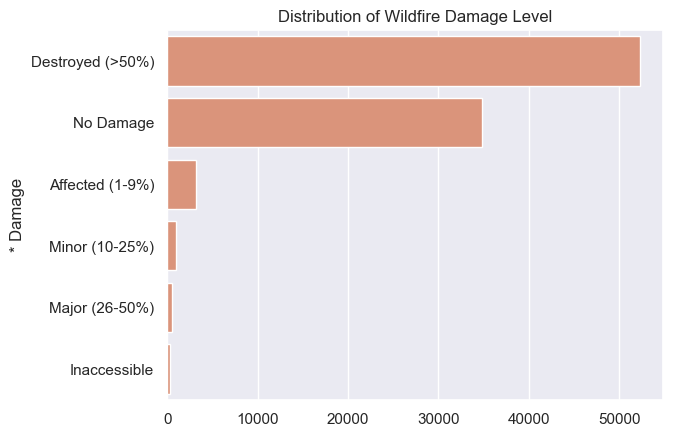

In [8]:
# Damage Distribution
sns.barplot(calfire_data.groupby('* Damage').size()
            .sort_values(ascending=False), orient='h')
plt.title('Distribution of Wildfire Damage Level')
plt.show()

In [9]:
# Map: Distribution of Wildfire Damage
damage_color = {
    'Destroyed (>50%)': 'red',
    'Major (26-50%)': 'darkorange',
    'Minor (10-25%)': 'orange',
    'Affected (1-9%)': 'yellow',
    'Inaccessible': 'greenyellow',
    'No Damage': 'green'
}

fig = go.Figure(go.Scattermapbox(
    mode="markers",
    lon=calfire_data['Longitude'],
    lat=calfire_data['Latitude'],
    marker={'size': 10,
            'color': [damage_color[damage]
                      for damage in calfire_data['* Damage']]},
    showlegend=False
))

north_south_line = 35.79889
fig.add_trace(go.Scattermapbox(
    mode='lines',
    lon=[-124, -114],
    lat=[north_south_line, north_south_line],
    line=dict(width=2, color='black'),
    showlegend=False
))

fig.update_layout(
    mapbox={
        'style': "open-street-map",
        'center': {'lon': calfire_data['Longitude'].mean(),
                   'lat': north_south_line},
        'zoom': 5},
    width=600,
    height=800,
    margin={'r': 0, 't': 0, 'l': 0, 'b': 0}
)

legend_annotations = []
for damage, color in damage_color.items():
    legend_annotations.append(
        dict(
            x=1,
            y=0.9 - list(damage_color.keys()).index(damage) * 0.1,
            xref='paper',
            yref='paper',
            text=damage,
            showarrow=False,
            bgcolor=color,
            font=dict(color='black')
        )
    )


fig.update_layout(annotations=legend_annotations)
fig.write_html("cawf_damage_map.html")
fig.show()

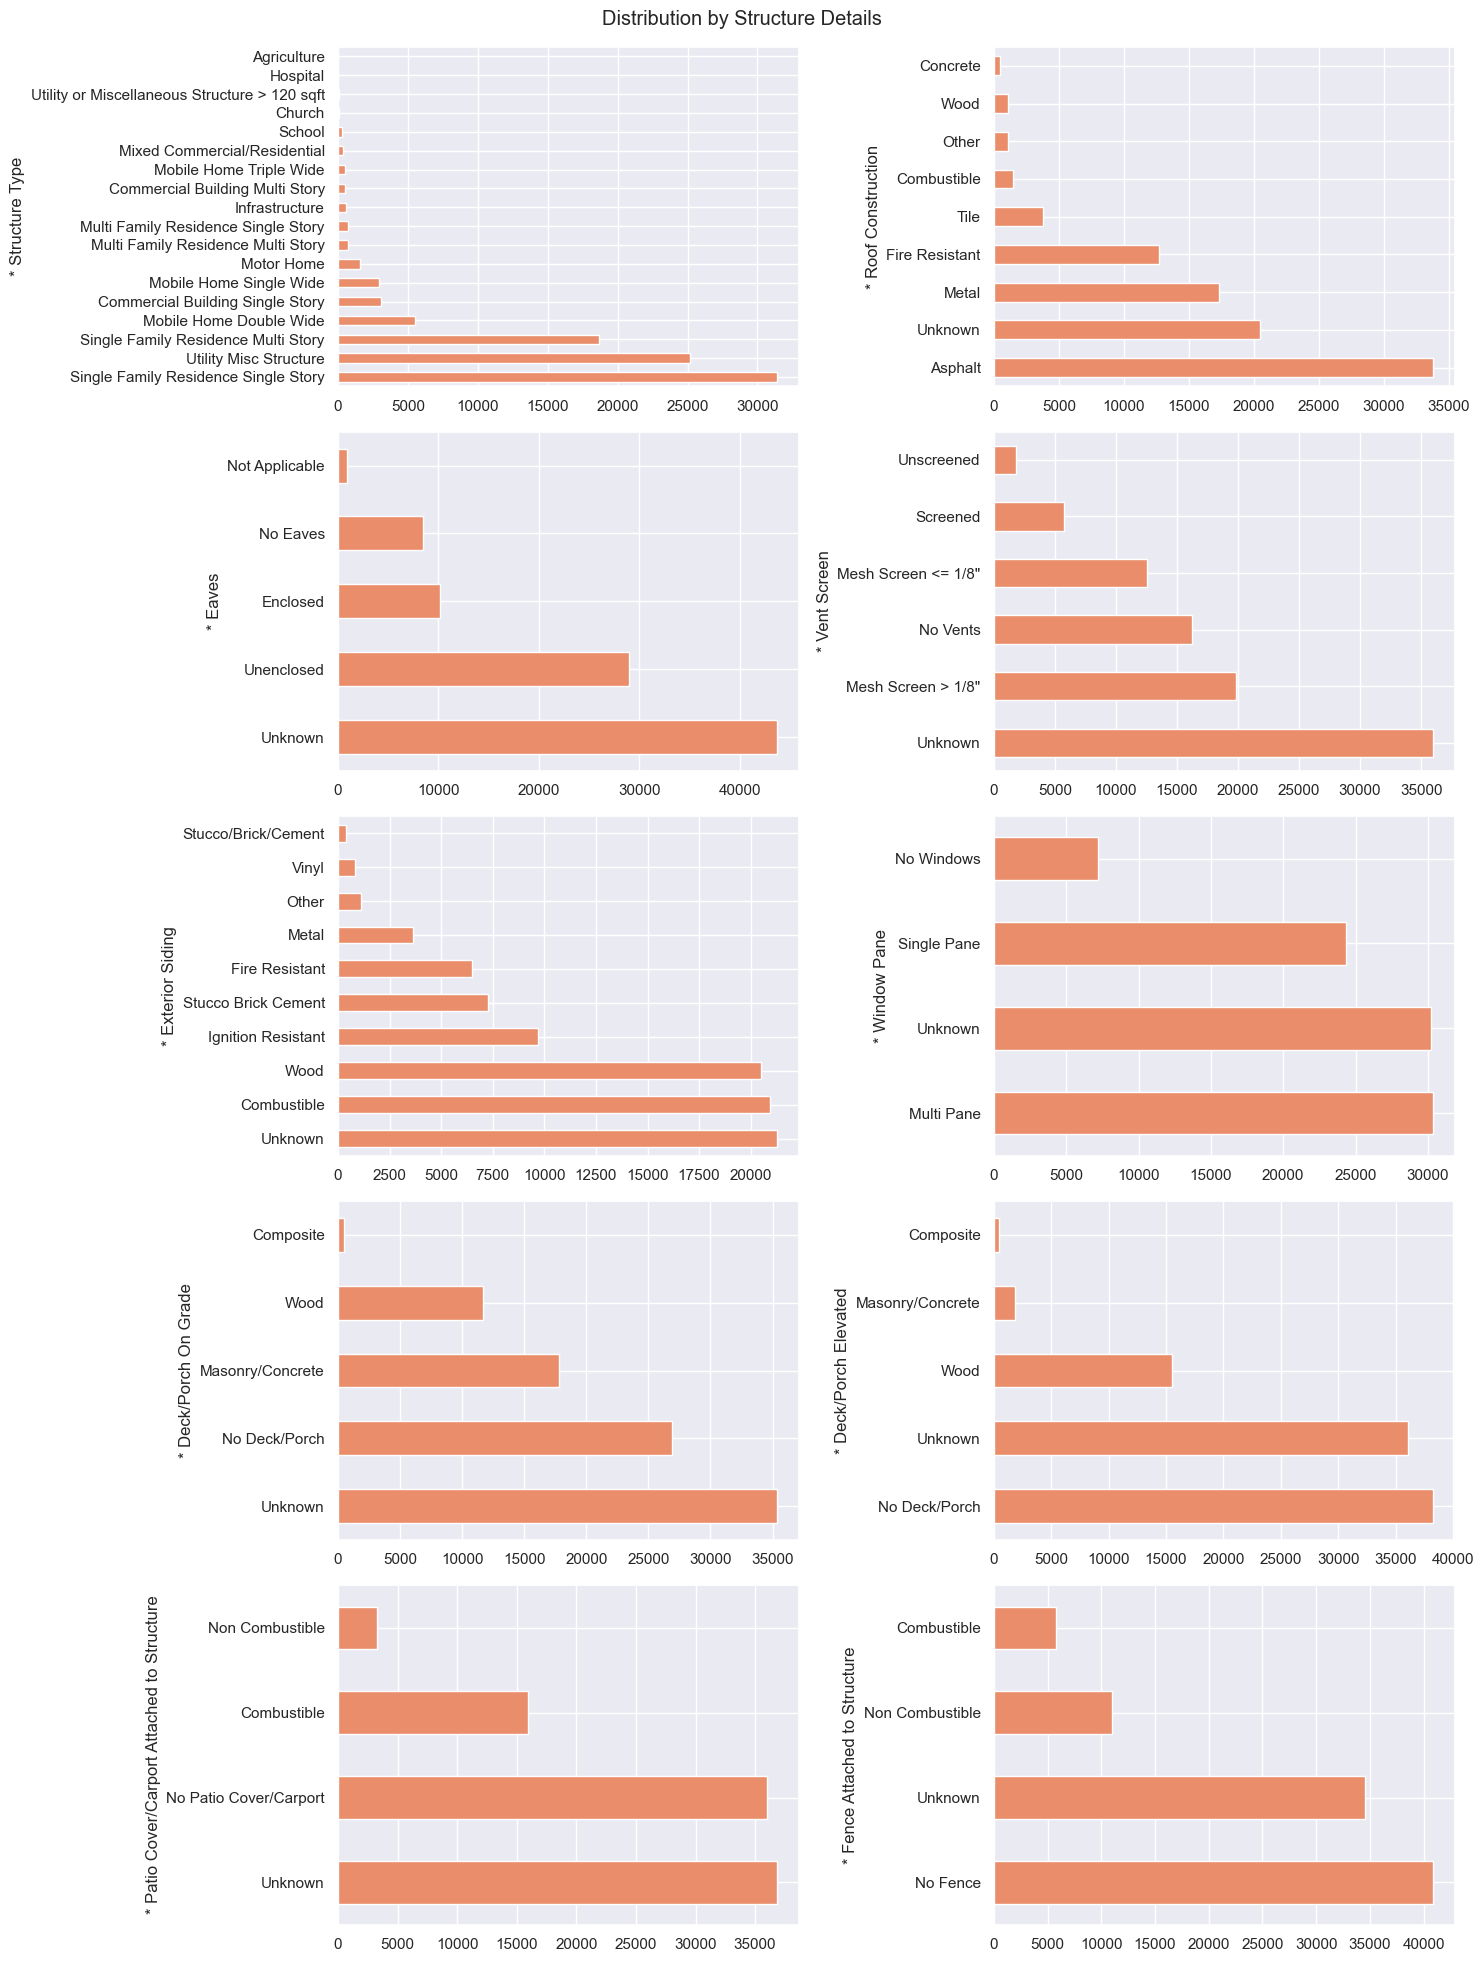

In [10]:
# Structure Details
fig, axs = plt.subplots(5, 2, figsize=(15, 20))
for ax, c in zip(axs.flatten(), categorical_cols):
    calfire_data_rel[c].value_counts().plot(kind='barh', ax=ax)
    
plt.suptitle("Distribution by Structure Details\n")
plt.tight_layout()
plt.show()

Data encoding is good quality, although with a high proportion of Unknown.

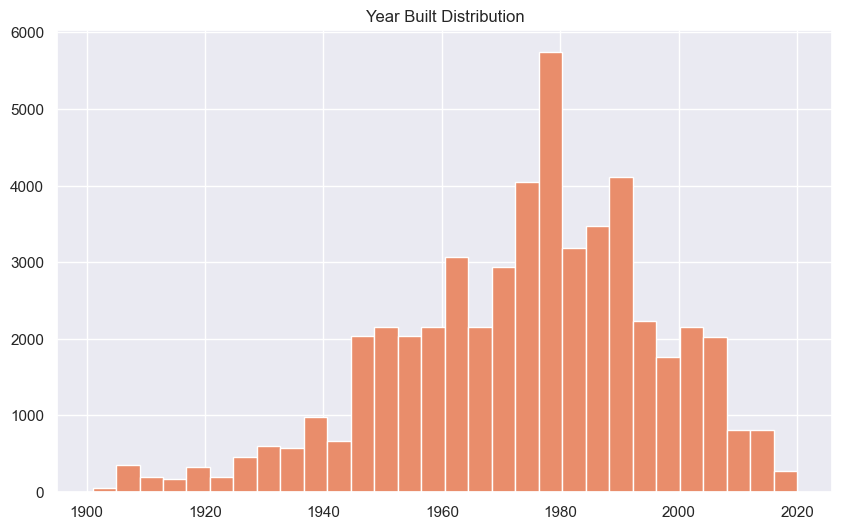

In [11]:
calfire_data.loc[calfire_data['Year Built (parcel)'] > 1900,
                 'Year Built (parcel)'].hist(bins=30, figsize=(10,6))
plt.title("Year Built Distribution")
plt.show()

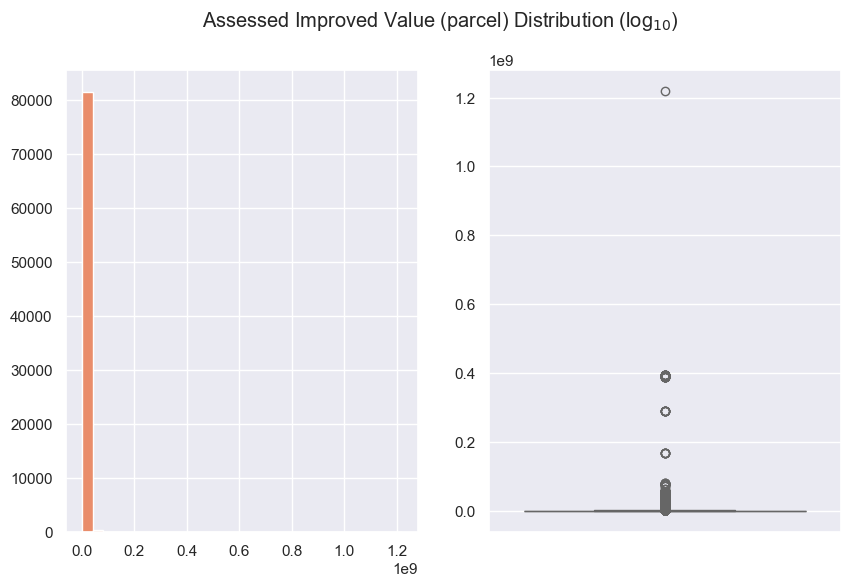

In [12]:
fig, ax = plt.subplots(1, 2)

(calfire_data_rel.loc[calfire_data_rel['Assessed Improved Value (parcel)'] > 0,
                      'Assessed Improved Value (parcel)']
 .hist(bins=30, figsize=(10,6), ax=ax[0]))

sns.boxplot(calfire_data_rel
            .loc[calfire_data_rel['Assessed Improved Value (parcel)'] > 0,
                 'Assessed Improved Value (parcel)'], ax=ax[1])
plt.ylabel('')

plt.suptitle("Assessed Improved Value (parcel) Distribution (log$_{10}$)")
plt.show()


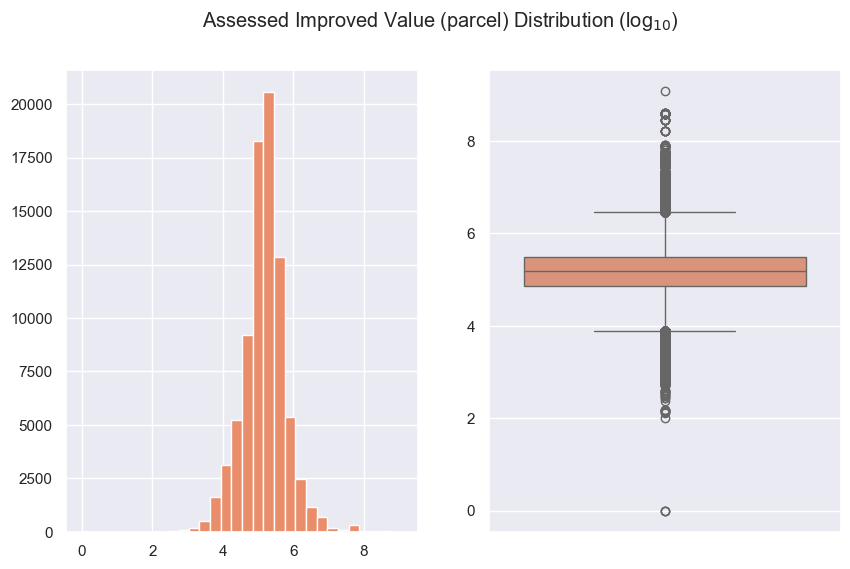

In [13]:
fig, ax = plt.subplots(1, 2)

(calfire_data_rel.loc[calfire_data_rel['Assessed Improved Value (parcel)'] > 0,
                      'Assessed Improved Value (parcel)']
 .map(np.log10).hist(bins=30, figsize=(10,6), ax=ax[0]))

sns.boxplot(calfire_data_rel
            .loc[calfire_data_rel['Assessed Improved Value (parcel)'] > 0,
                 'Assessed Improved Value (parcel)']
            .map(np.log10), ax=ax[1])
plt.ylabel('')

plt.suptitle("Assessed Improved Value (parcel) Distribution (log$_{10}$)")
plt.show()


Assessed values seem to follow a lognormal distribution.

## Machine Learning
We keep 20% of the dataset as our holdout set for testing, and use the remaining 80% to train and validate models.

In [14]:
trainval, test = train_test_split(calfire_data_rel, test_size=0.2,
                                  random_state=221)

In [15]:
test.columns

Index(['OBJECTID', '* Damage', '* Structure Type', '* Roof Construction',
       '* Eaves', '* Vent Screen', '* Exterior Siding', '* Window Pane',
       '* Deck/Porch On Grade', '* Deck/Porch Elevated',
       '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure', 'Distance - Propane Tank to Structure',
       'Assessed Improved Value (parcel)', 'Year Built (parcel)', 'Latitude',
       'Longitude'],
      dtype='object')

### Feature Engineering

In [16]:
class CalFireFeatureEngg:
    
    categorical_cols = [
        '* Structure Type',
        '* Roof Construction',
        '* Eaves',
        '* Vent Screen',
        '* Exterior Siding',
        '* Window Pane',
        '* Deck/Porch On Grade',
        '* Deck/Porch Elevated',
        '* Patio Cover/Carport Attached to Structure',
        '* Fence Attached to Structure'
    ]
    
    def __init__(self):
        self.feat_cols = []
    
    def _ohe(self):
        """Perform OHE on categorical columns."""
        encoder = OneHotEncoder(sparse_output=False)
        catcols_encoded = encoder.fit_transform(self._data[categorical_cols])
        self.feat_cols.append(
            pd.DataFrame(
                catcols_encoded, 
                columns=encoder.get_feature_names_out(categorical_cols)
            ))
    
    def _yrblt_scaler(self):
        """Scale Year Built using MinMaxScaler."""
        mean_year = int(self._data['Year Built (parcel)'].mean())
        years = self._data[['Year Built (parcel)']].fillna(mean_year)
        
        scaler = MinMaxScaler()
        years_scaled = scaler.fit_transform(years)
        self.feat_cols.append(pd.DataFrame(years_scaled,
                                           columns=['Year Built (scaled)']))
        
    def _value_scaler(self):
        """Scale Log of Assessed Value using StandardScaler."""
        val_df = self._data[['Assessed Improved Value (parcel)']].copy()
        val_df.loc[val_df['Assessed Improved Value (parcel)']==0, 'Assessed Improved Value (parcel)'] = 0.001
        val_df['Assessed Improved Value (parcel)'] = val_df['Assessed Improved Value (parcel)'].map(np.log10)
        scaler = StandardScaler()
        log_scaled = scaler.fit_transform(val_df)
        self.feat_cols.append(pd.DataFrame(log_scaled,
                                           columns=['Log Assessed Value']))
        
        
    def _transform_latlon(self, longitude, latitude):
        """Transform lat/lon data to meters using EPSG 5070 (CONUS)."""
        transformer = pyproj.Transformer.from_crs('EPSG:4326', 'EPSG:5070')
        x_Lon, y_Lat = transformer.transform(
            self._data['Longitude'], self._data['Latitude'])
        return x_Lon, y_Lat
    
    def _transform_latlon_cols(self):
        """Apply transformation to lat/lon columns and return pd.Series."""
        transformed_xy = self._data.apply(
            lambda row: self._transform_latlon(row['Longitude'], row['Latitude']),
            axis=1
        )
        
        self.feat_cols.append(pd.DataFrame(transformed_xy.tolist(),
                                           columns=['x_Lon', 'y_Lat']))
    
    def _target(self):
        y_cat = self._data['* Damage']
        damage_map = {
            'Destroyed (>50%)': 1,
            'No Damage': 0,
            'Affected (1-9%)': 0.10,
            'Minor (10-25%)': 0.25,
            'Major (26-50%)': 0.50,
            'Inaccessible': 0
        }
        y = y_cat.map(damage_map)
        y.index = self._data['OBJECTID']
        return y
    
    def transform(self, data):
        """Apply transformations to return feature matrix and target array."""
        self._data = data

        self._ohe()
        self._yrblt_scaler()
        self._value_scaler()
        #self._transform_latlon_cols()
        
        
        self.X = self.feat_cols[0]
        for df in self.feat_cols[1:]:
            self.X = pd.merge(self.X, df, left_index=True, right_index=True)
            
        self.X.index = self._data['OBJECTID']
        self.y = self._target()
        
        return self.X, self.y


In [21]:
calfiretransform = CalFireFeatureEngg()

X, y = calfiretransform.transform(calfire_data_rel)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, train_size=0.2, random_state=221)

### Model Training

In [18]:
n_trials = 10
neighbors_range = [2*k+1 for k in range(1,10)]
alpha_range = [10**(k-3) for k in range(4)]
max_depth_range = list(range(9, 21))
learning_rate_range = [0.01, 0.1, 0.2]


def _train_knn(X, y):
    print('Running kNN...')
    score_train = []
    score_test = []
    
    times = []
    for seed in range(n_trials):
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )
        acc_train = []
        acc_test = []
        
        for n_neighbors in neighbors_range:
            start_time = time.time()
            reg = KNeighborsRegressor(n_neighbors=n_neighbors)
            reg.fit(X_train, y_train)
            acc_train.append(reg.score(X_train, y_train))
            acc_test.append(reg.score(X_val, y_val))
            times.append(time.time() - start_time)
            
        score_train.append(acc_train)
        score_test.append(acc_test)
        
    score = np.mean(score_test, axis=0)
    avg_run_time = np.mean(times)
    return ['kNN Regressor',
            np.amax(score),
            {'N_Neighbor': neighbors_range[np.argmax(score)]},
            'NA',
            avg_run_time]
    
def _train_lasso(X, y):
    print('Running Lasso Regression...')
    score_train = []
    score_test = []
    weighted_coefs = []
    
    times = []
    for seed in range(n_trials):
        train_accuracy = []
        test_accuracy = []
        
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )
        for alpha in alpha_range:
            start_time = time.time()
            reg = Lasso(alpha=alpha)
            reg.fit(X_train, y_train)
            
            train_accuracy.append(reg.score(X_train, y_train))
            test_accuracy.append(reg.score(X_val, y_val))
            coefs = reg.coef_
            weighted_coefs.append(coefs)
            times.append(time.time() - start_time)
            
        score_train.append(train_accuracy)
        score_test.append(test_accuracy)
        
    mean_coefs = np.mean(weighted_coefs, axis=0)
    score = np.mean(score_test, axis=0)
    
    top_predictor = X.columns[np.argmax(np.abs(mean_coefs))]
    avg_run_time = np.mean(times)
    
    return ['Lasso',
            np.amax(score),
            {'alpha': alpha_range[np.argmax(score)]},
            top_predictor,
            avg_run_time]
    
def _train_ridge(X, y):
    print('Running Ridge Regression...')
    score_train = []
    score_test = []
    weighted_coefs = []
    
    times = []
    for seed in range(n_trials):
        train_accuracy = []
        test_accuracy = []
        
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )
        for alpha in alpha_range:
            start_time = time.time()
            reg = Ridge(alpha=alpha)
            reg.fit(X_train, y_train)
            
            train_accuracy.append(reg.score(X_train, y_train))
            test_accuracy.append(reg.score(X_val, y_val))
            coefs = reg.coef_
            weighted_coefs.append(coefs)
            times.append(time.time() - start_time)
            
        score_train.append(train_accuracy)
        score_test.append(test_accuracy)
        
    mean_coefs = np.mean(weighted_coefs, axis=0)
    score = np.mean(score_test, axis=0)
    
    top_predictor = X.columns[np.argmax(np.abs(mean_coefs))]
    avg_run_time = np.mean(times)
    
    return ['Ridge',
            np.amax(score),
            f'alpha = {alpha_range[np.argmax(score)]}',
            top_predictor,
            avg_run_time]
        
def _train_svr(X, y):
    print('Running SVR...')
    score_train = []
    score_test = []
    weighted_coefs = []
    
    times = []
    for seed in range(n_trials):
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )
        acc_train = []
        acc_test = []
        for C in alpha_range:
            start_time = time.time()
            reg = SVR(C=C, kernel='linear')
            reg.fit(X_train, y_train)
            acc_train.append(reg.score(X_train, y_train))
            acc_test.append(reg.score(X_val, y_val))
            
            coefs = reg.coef_
            weighted_coefs.append(coefs)
            times.append(time.time() - start_time)
            
        score_train.append(acc_train)
        score_test.append(acc_test)
        
    mean_coefs = np.mean(weighted_coefs, axis=0)
    score = np.mean(score_test, axis=0)
    
    top_predictor = X.columns[np.argmax(np.abs(mean_coefs))]
    avg_run_time = np.mean(times)
    
    return ['SVR',
            np.amax(score),
            {'C': alpha_range[np.argmax(score)]},
            top_predictor,
            avg_run_time]
    
def _train_rf(X, y):
    print('Running RandomForestRegressor...')
    score_train = []
    score_test = []
    weighted_coefs = []
    
    times = []
    for seed in range(n_trials):
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )
        acc_train = []
        acc_test = []
        for max_depth in max_depth_range:
            start_time = time.time()
            reg = RandomForestRegressor(max_depth=max_depth)
            reg.fit(X_train, y_train)
            acc_train.append(reg.score(X_train, y_train))
            acc_test.append(reg.score(X_val, y_val))
            
            coefs = reg.feature_importances_
            weighted_coefs.append(coefs)
            times.append(time.time() - start_time)
            
        score_train.append(acc_train)
        score_test.append(acc_test)
        
    mean_coefs = np.mean(weighted_coefs, axis=0)
    score = np.mean(score_test, axis=0)
    
    top_predictor = X.columns[np.argmax(np.abs(mean_coefs))]
    avg_run_time = np.mean(times)
    
    return ['RandomForest',
            np.amax(score),
            {'max_depth': max_depth_range[np.argmax(score)]},
            top_predictor,
            avg_run_time]
    
def _train_gb(X, y):
    print('Running Gradient Boosting...')
    score_train = []
    score_test = []
    weighted_coefs = []
    param_choices = list(product(max_depth_range, learning_rate_range))
    
    # Clean feature names for xgboost
    clean_cols = [c.replace(",", "").replace("<", "") for c in X.columns]
    X.columns = clean_cols

    times = []
    for seed in range(n_trials):
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )
        acc_train = []
        acc_test = []
        
        for max_depth, lr in param_choices:
            start_time = time.time()
            reg = GradientBoostingRegressor(max_depth=max_depth, learning_rate=lr)
            reg.fit(X_train, y_train)
            acc_train.append(reg.score(X_train, y_train))
            acc_test.append(reg.score(X_val, y_val))
            
            coefs = reg.feature_importances_
            weighted_coefs.append(coefs)
            times.append(time.time() - start_time)
            
        score_train.append(acc_train)
        score_test.append(acc_test)
        
    mean_coefs = np.mean(weighted_coefs, axis=0)
    score = np.mean(score_test, axis=0)
    
    top_predictor = X.columns[np.argmax(np.abs(mean_coefs))]
    avg_run_time = np.mean(times)
    best_max_depth = max_depth_range[np.argmax(score) // len(learning_rate_range)]
    best_lr = learning_rate_range[np.argmax(score) % len(max_depth_range)]
    
    return ['Gradient Boosting',
            np.amax(score),
            {'max_depth': best_max_depth, 'learning_rate': best_lr},
            top_predictor,
            avg_run_time]
    

a = _train_knn(X_trainval, y_trainval)
b = _train_lasso(X_trainval, y_trainval)
c = _train_ridge(X_trainval, y_trainval)
d = _train_svr(X_trainval, y_trainval)
e = _train_rf(X_trainval, y_trainval)
f = _train_gb(X_trainval, y_trainval)

Running kNN...


Running Lasso Regression...
Running Ridge Regression...
Running SVR...
Running RandomForestRegressor...
Running Gradient Boosting...


In [19]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter',
        'Top Predictor Variable', 'Run Time']
results = [a, b, c, d, e, f]
results_df = pd.DataFrame(columns=cols)

for i, res in enumerate(results):
    results_df.loc[i] = res

results_df

Machine Learning Method  Test Accuracy  \
0           kNN Regressor       0.576695   
1                   Lasso       0.512129   
2                   Ridge       0.519556   
3                     SVR       0.451143   
4            RandomForest       0.647468   
5       Gradient Boosting       0.649792   

                           Best Parameter         Top Predictor Variable  \
0                      {'N_Neighbor': 13}                             NA   
1                        {'alpha': 0.001}    * Roof Construction_Unknown   
2                               alpha = 1    * Roof Construction_Unknown   
3                            {'C': 0.001}         * Exterior Siding_Wood   
4                       {'max_depth': 17}  * Exterior Siding_Combustible   
5  {'max_depth': 9, 'learning_rate': 0.1}  * Exterior Siding_Combustible   

    Run Time  
0   0.300448  
1   0.535225  
2   0.020309  
3  14.187872  
4   4.237519  
5   7.435024

We pick Random Forest as our best model since it gives us a high score with significantly shorter run time than Gradient Boosting

## Model Results
Now that we have identified a model to use, we then look at the features it deem important and look at the implications.

In [26]:
best_model = RandomForestRegressor(max_depth=17)
best_model.fit(X_trainval, y_trainval)
print(f"Test R^2: {best_model.score(X_test, y_test):.4f}")

Test R^2: 0.6475


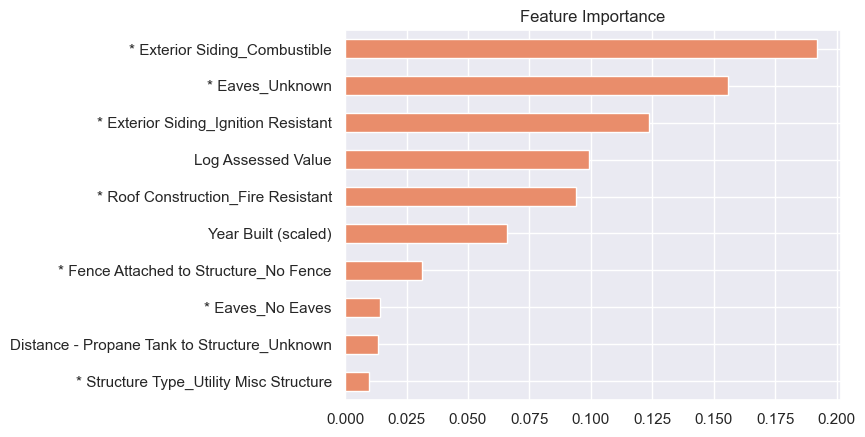

In [24]:
feat_impt = pd.Series(best_model.feature_importances_,
                         index=best_model.feature_names_in_)
feat_impt.sort_values().tail(10).plot(kind='barh')
plt.title('Feature Importance')
plt.show()

The top features in terms of importance actually makes sense from a catastrophe risk practitioner's standpoint. We recognize that construction materials have a significant effect on a structure's vulnerability, especially roof and exterior sidings for fire risk, as well as the value and age of the structure. An interesting discovery here is the emergence of Eaves and Fence in the top 10 in feature importance - these relates to the concept of defensible space, or the space between a structure and the nearest tree line that may be possibly burning, and makes sense to be featured highly in a wildfire damage model.

## Conclusion
We were able to develop a model with a 64.75% accuracy and, more importantly, very explainable feature importances. For insurance companies, this can be useful in prioritizing which data to gather for pricing purposes. Civil society can use this to guide policies and to promote or discourage certain building practices.

## References
[1] Swiss Re (14 Dec 2023). _Natural catastrophes in focus: Wildfires_. Swiss Re Group. https://www.swissre.com/risk-knowledge/mitigating-climate-risk/wildfires.html

[2] California State Geoportal (13 Dec 2018). _CAL FIRE Wildfire Damage Inspection Template - GDB_. https://gis.data.ca.gov/datasets/1b1c428af1f74a8c912f4b5c9e40d51e/about. Updated 29 Sep 2022.